# Kinodynamic Diffusion Planner — Dynobench Edition

This notebook adapts the diffusion-based kinodynamic planner to **Dynobench** environments (no D4RL / MuJoCo).

Default benchmark used here:
- **Robot:** `integrator2_2d_v0` (state `[x,y,vx,vy]`, control `[ax,ay]`)
- **Scenario:** `envs/integrator2_2d_v0/park.yaml`

The env/model files are fetched from the Dynobench GitHub repo at runtime and parsed.


---
## 1. Setup & Installation

In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib tqdm requests --quiet

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np, matplotlib.pyplot as plt, math, os, requests, time, re
from matplotlib.patches import Rectangle
from tqdm.auto import tqdm
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("✓ Setup complete!")


Device: cuda
GPU: Tesla T4
✓ Setup complete!


---
## 2. Module 1: Dynamics

Implements differentiable dynamics for trajectory rollout.

**Key Classes:**
- `BaseDynamics`: Abstract dynamics interface
- `SingleIntegrator2D`: Simple position control (state=[x,y], control=[vx,vy])
- `PointMass2D`: With velocity dynamics (state=[x,y,vx,vy], control=[ax,ay])
- `DifferentiableRollout`: Rolls out controls through dynamics with gradient flow

In [2]:

class BaseDynamics(nn.Module):
    """Abstract base class for dynamics models"""

    def __init__(self, state_dim, control_dim, dt=0.1):
        super().__init__()
        self.state_dim = state_dim
        self.control_dim = control_dim
        self.dt = dt

    def forward(self, x, u):
        raise NotImplementedError


class PointMass2D(BaseDynamics):
    """2D point mass with velocity: state=[x,y,vx,vy], control=[ax,ay]"""

    def __init__(self, dt=0.1, max_velocity=2.0, damping=0.9):
        super().__init__(state_dim=4, control_dim=2, dt=dt)
        self.max_velocity = max_velocity
        self.damping = damping

    def forward(self, x, u):
        pos = x[..., :2]
        vel = x[..., 2:]

        vel_new = self.damping * vel + self.dt * u
        vel_new = torch.clamp(vel_new, -self.max_velocity, self.max_velocity)
        pos_new = pos + self.dt * vel_new

        return torch.cat([pos_new, vel_new], dim=-1)


class SingleIntegrator2D(BaseDynamics):
    """Simple velocity control: state=[x,y], control=[vx,vy]"""

    def __init__(self, dt=0.1):
        super().__init__(state_dim=2, control_dim=2, dt=dt)

    def forward(self, x, u):
        return x + self.dt * u


class DifferentiableRollout(nn.Module):
    """Roll out controls through dynamics (enables backprop)"""

    def __init__(self, dynamics):
        super().__init__()
        self.dynamics = dynamics

    def forward(self, x0, controls):
        batch_size, T = controls.shape[:2]
        state_dim = self.dynamics.state_dim

        states = torch.zeros(batch_size, T + 1, state_dim,
                           device=x0.device, dtype=x0.dtype)
        states[:, 0] = x0

        x = x0
        for t in range(T):
            u = controls[:, t]
            x = self.dynamics(x, u)
            states[:, t + 1] = x

        return states


# Test
print("Testing dynamics...")
dynamics = SingleIntegrator2D()
rollout = DifferentiableRollout(dynamics)
x0 = torch.zeros(2, 2)
controls = torch.randn(2, 10, 2)
states = rollout(x0, controls)
print(f"✓ Rollout shape: {states.shape} (batch=2, T+1=11, state_dim=2)")


Testing dynamics...
✓ Rollout shape: torch.Size([2, 11, 2]) (batch=2, T+1=11, state_dim=2)


---
## 3. Module 2: Diffusion Model

Temporal U-Net for denoising control sequences + DDPM implementation.

**Architecture:**
- Sinusoidal time embeddings for diffusion step k
- 1D temporal convolutions for sequence processing
- U-Net with skip connections
- FiLM conditioning on time and task (start, goal)

In [3]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb


class TemporalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.norm = nn.GroupNorm(min(8, out_channels), out_channels)
        self.act = nn.Mish()

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))


class TemporalUNet(nn.Module):
    """
    Temporal U-Net for denoising control sequences.

    IMPORTANT FIX:
    The original notebook computed a condition embedding but never used it,
    which effectively made the diffusion model unconditional. This version
    injects the condition embedding at multiple resolutions (FiLM-style additive bias),
    so the model can actually plan conditioned on (x0, x_goal).
    """

    def __init__(self, control_dim, hidden_dim=128, time_emb_dim=64, cond_dim=32):
        super().__init__()
        self.control_dim = control_dim

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.Mish(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.cond_encoder = nn.Sequential(
            nn.Linear(cond_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Encoder
        self.enc1 = TemporalConvBlock(control_dim, hidden_dim // 2)
        self.enc2 = TemporalConvBlock(hidden_dim // 2, hidden_dim)
        self.enc3 = TemporalConvBlock(hidden_dim, hidden_dim * 2)

        # Bottleneck
        self.bottleneck = TemporalConvBlock(hidden_dim * 2, hidden_dim * 2)

        # Decoder
        self.dec3 = TemporalConvBlock(hidden_dim * 4, hidden_dim)
        self.dec2 = TemporalConvBlock(hidden_dim * 2, hidden_dim // 2)
        self.dec1 = TemporalConvBlock(hidden_dim, hidden_dim // 2)

        self.out = nn.Conv1d(hidden_dim // 2, control_dim, 1)

        # Time modulation (additive)
        self.time_mod = nn.ModuleList([
            nn.Linear(time_emb_dim, hidden_dim // 2),
            nn.Linear(time_emb_dim, hidden_dim),
            nn.Linear(time_emb_dim, hidden_dim * 2),
            nn.Linear(time_emb_dim, hidden_dim * 2),
        ])

        # Condition modulation (additive)
        self.cond_mod = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.Linear(hidden_dim, hidden_dim * 2),
        ])

    def forward(self, u_noisy, k, condition):
        # u_noisy: [B, T, control_dim]
        x = u_noisy.transpose(1, 2)  # [B, control_dim, T]

        t_emb = self.time_mlp(k.float())         # [B, time_emb_dim]
        c_emb = self.cond_encoder(condition)     # [B, hidden_dim]

        # Encoder
        e1 = self.enc1(x) + self.time_mod[0](t_emb)[:, :, None] + self.cond_mod[0](c_emb)[:, :, None]
        e2_in = F.avg_pool1d(e1, 2)
        e2 = self.enc2(e2_in) + self.time_mod[1](t_emb)[:, :, None] + self.cond_mod[1](c_emb)[:, :, None]

        e3_in = F.avg_pool1d(e2, 2)
        e3 = self.enc3(e3_in) + self.time_mod[2](t_emb)[:, :, None] + self.cond_mod[2](c_emb)[:, :, None]

        # Bottleneck
        b_in = F.avg_pool1d(e3, 2)
        b = self.bottleneck(b_in) + self.time_mod[3](t_emb)[:, :, None] + self.cond_mod[3](c_emb)[:, :, None]

        # Decoder with skip connections
        d3 = F.interpolate(b, size=e3.shape[-1], mode='linear', align_corners=False)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = F.interpolate(d3, size=e2.shape[-1], mode='linear', align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = F.interpolate(d2, size=e1.shape[-1], mode='linear', align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.out(d1)  # [B, control_dim, T]
        return out.transpose(1, 2)  # [B, T, control_dim]


class ControlDiffusion(nn.Module):
    """DDPM for control sequences"""

    def __init__(self, denoiser, T_diffusion=100, beta_schedule='linear'):
        super().__init__()
        self.denoiser = denoiser
        self.T_diffusion = T_diffusion

        if beta_schedule == 'linear':
            betas = torch.linspace(1e-4, 0.02, T_diffusion)
        else:
            s = 0.008
            steps = T_diffusion + 1
            x = torch.linspace(0, T_diffusion, steps)
            alphas_cumprod = torch.cos(((x / T_diffusion) + s) / (1 + s) * np.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            betas = torch.clamp(betas, 0, 0.999)

        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))

    def q_sample(self, u0, k, noise=None):
        if noise is None:
            noise = torch.randn_like(u0)

        sqrt_alpha_cumprod = self.sqrt_alphas_cumprod[k][:, None, None]
        sqrt_one_minus = self.sqrt_one_minus_alphas_cumprod[k][:, None, None]

        u_k = sqrt_alpha_cumprod * u0 + sqrt_one_minus * noise
        return u_k, noise

    def p_sample(self, u_t, t, condition):
        """
        DDPM posterior sampling step:
        u_t -> u_{t-1}
        u_t: [B, T, C]
        t  : [B] long (all same during sampling, but this supports per-element)
        """
        eps = self.denoiser(u_t, t, condition)  # predicted noise, [B,T,C]

        abar_t = self.alphas_cumprod[t][:, None, None]          # \bar{alpha}_t
        alpha_t = self.alphas[t][:, None, None]                # alpha_t
        beta_t  = self.betas[t][:, None, None]                 # beta_t

        # Predict u0
        u0_hat = (u_t - torch.sqrt(1.0 - abar_t) * eps) / torch.sqrt(abar_t)

        # Previous cumulative alpha
        abar_prev = torch.where(
            (t > 0)[:, None, None],
            self.alphas_cumprod[(t - 1).clamp(min=0)][:, None, None],
            torch.ones_like(abar_t)
        )

        # DDPM posterior variance: beta_tilde = beta_t * (1-abar_prev)/(1-abar_t)
        beta_tilde = beta_t * (1.0 - abar_prev) / (1.0 - abar_t)
        sigma = torch.sqrt(beta_tilde)

        # DDPM posterior mean:
        # mu = (sqrt(abar_prev)*beta_t/(1-abar_t))*u0_hat + (sqrt(alpha_t)*(1-abar_prev)/(1-abar_t))*u_t
        coef1 = torch.sqrt(abar_prev) * beta_t / (1.0 - abar_t)
        coef2 = torch.sqrt(alpha_t) * (1.0 - abar_prev) / (1.0 - abar_t)
        mu = coef1 * u0_hat + coef2 * u_t

        noise = torch.randn_like(u_t)
        nonzero = (t > 0)[:, None, None].float()
        return mu + nonzero * sigma * noise

    def p_sample_ddim(self, u_t, t, condition, eta: float = 0.0):
        """
        DDIM sampling step (eta=0 => deterministic).
        u_t -> u_{t-1}
        """
        eps = self.denoiser(u_t, t, condition)

        abar_t = self.alphas_cumprod[t][:, None, None]
        alpha_t = self.alphas[t][:, None, None]

        # Predict u0
        u0_hat = (u_t - torch.sqrt(1.0 - abar_t) * eps) / torch.sqrt(abar_t)

        abar_prev = torch.where(
            (t > 0)[:, None, None],
            self.alphas_cumprod[(t - 1).clamp(min=0)][:, None, None],
            torch.ones_like(abar_t)
        )

        # DDIM sigma (controls stochasticity)
        sigma = eta * torch.sqrt((1.0 - abar_prev) / (1.0 - abar_t) * (1.0 - alpha_t))
        # ensure numeric stability inside sqrt
        eps_coeff = torch.sqrt(torch.clamp(1.0 - abar_prev - sigma * sigma, min=0.0))

        noise = torch.randn_like(u_t)
        nonzero = (t > 0)[:, None, None].float()
        u_prev = torch.sqrt(abar_prev) * u0_hat + eps_coeff * eps + nonzero * sigma * noise
        return u_prev




    @torch.no_grad()
    def sample(self, shape, condition, method: str = 'ddim', eta: float = 0.0):
        """
        Sample control sequences.
          method: 'ddim' (recommended for planning) or 'ddpm'
          eta: DDIM stochasticity (0.0 deterministic)
        """
        device = self.betas.device
        u = torch.randn(shape, device=device)

        for i in reversed(range(self.T_diffusion)):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)
            if method.lower() == 'ddpm':
                u = self.p_sample(u, t, condition)
            else:
                u = self.p_sample_ddim(u, t, condition, eta=eta)

        return u


print("✓ Diffusion model defined (conditioning FIXED)")


✓ Diffusion model defined (conditioning FIXED)


---
## 4. Module 3: Constraints + BoxSDF

**New:** `BoxSDF2D` models axis-aligned rectangular obstacles (maze walls).
`MazeSDF2D` combines circular and rectangular SDFs seamlessly.


In [4]:
# ── Circular SDF (unchanged from synthetic version) ─────────────────────────
class SignedDistanceField2D(nn.Module):
    def __init__(self, obstacles, grid_size=100, bounds=(-1,1), precompute_grid=True):
        super().__init__()
        self.obstacles = obstacles
        self.bounds = bounds
        if obstacles:
            centers = torch.tensor([c for (c,r) in obstacles], dtype=torch.float32)
            radii   = torch.tensor([r for (c,r) in obstacles], dtype=torch.float32)
        else:
            centers = torch.zeros(0, 2)
            radii   = torch.zeros(0)
        self.register_buffer('centers', centers)
        self.register_buffer('radii', radii)
        self.sdf_grid = self._compute_sdf_grid(grid_size) if precompute_grid and obstacles else None

    def _compute_sdf_grid(self, grid_size):
        x = torch.linspace(self.bounds[0], self.bounds[1], grid_size)
        y = torch.linspace(self.bounds[0], self.bounds[1], grid_size)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        return self(torch.stack([xx, yy], dim=-1))

    def forward(self, positions):
        if self.centers.numel() == 0:
            return torch.full(positions.shape[:-1], 1e6, device=positions.device, dtype=positions.dtype)
        centers = self.centers.to(positions.device, dtype=positions.dtype)
        radii   = self.radii.to(positions.device, dtype=positions.dtype)
        diff = positions[..., None, :] - centers
        dist = torch.sqrt((diff*diff).sum(-1) + 1e-9)
        return torch.min(dist - radii, dim=-1).values


# ── NEW: Box SDF ──────────────────────────────────────────────────────────────
class BoxSDF2D(nn.Module):
    """
    Signed distance field for axis-aligned rectangular obstacles.
    boxes: list of ((cx, cy), (hx, hy)) — centre + half-extents.
    Fully differentiable (except at corners, measure zero).
    """
    def __init__(self, boxes):
        super().__init__()
        self.boxes = boxes
        centers = torch.tensor([[cx, cy] for (cx,cy),_ in boxes], dtype=torch.float32)
        halfs   = torch.tensor([[hx, hy] for _,(hx,hy) in boxes], dtype=torch.float32)
        self.register_buffer('centers', centers)
        self.register_buffer('halfs',   halfs)

    def forward(self, positions):
        centers = self.centers.to(positions.device, dtype=positions.dtype)
        halfs   = self.halfs.to(positions.device, dtype=positions.dtype)
        # [..., N, 2]
        d = torch.abs(positions[..., None, :] - centers) - halfs
        d_out  = torch.sqrt((d.clamp(min=0)**2).sum(-1) + 1e-9)   # [..., N]
        d_in   = d.max(dim=-1).values.clamp(max=0)                  # [..., N]
        return torch.min(d_out + d_in, dim=-1).values               # [...]


# ── Combined maze SDF ─────────────────────────────────────────────────────────
class MazeSDF2D(nn.Module):
    """Union of circular and rectangular obstacles.  min(sdf_circles, sdf_boxes)."""
    def __init__(self, circle_obstacles=None, box_obstacles=None):
        super().__init__()
        self.has_circles = bool(circle_obstacles)
        self.has_boxes   = bool(box_obstacles)
        if self.has_circles:
            self.circle_sdf = SignedDistanceField2D(circle_obstacles, precompute_grid=False)
        if self.has_boxes:
            self.box_sdf = BoxSDF2D(box_obstacles)

    def forward(self, positions):
        sdfs = []
        if self.has_circles:
            sdfs.append(self.circle_sdf(positions))
        if self.has_boxes:
            sdfs.append(self.box_sdf(positions))
        if not sdfs:
            return torch.full(positions.shape[:-1], 1e6, device=positions.device)
        return torch.stack(sdfs, dim=-1).min(dim=-1).values


# ── Constraint function ───────────────────────────────────────────────────────
class ConstraintFunction(nn.Module):
    def __init__(self, dynamics, sdf, delta=0.05,
                 goal_weight=10.0, obstacle_weight=100.0,
                 control_weight=0.1, smooth_weight=0.0):
        super().__init__()
        self.dynamics        = dynamics
        self.sdf             = sdf
        self.delta           = delta
        self.goal_weight     = goal_weight
        self.obstacle_weight = obstacle_weight
        self.control_weight  = control_weight
        self.smooth_weight   = smooth_weight

    def forward(self, controls, x0, x_goal, return_components=False):
        B, T = controls.shape[:2]
        states = torch.zeros(B, T+1, self.dynamics.state_dim,
                             device=controls.device, dtype=x0.dtype)
        states[:,0] = x0
        x = x0
        for t in range(T):
            x = self.dynamics(x, controls[:,t])
            states[:,t+1] = x
        positions  = states[..., :2]
        goal_cost  = ((positions[:,-1] - x_goal[...,:2])**2).sum(-1)
        sdf_vals   = self.sdf(positions)
        obs_cost   = F.relu(self.delta - sdf_vals).pow(2).sum(-1)
        ctrl_cost  = (controls**2).sum((1,2))
        smth_cost  = torch.zeros_like(goal_cost)
        if self.smooth_weight > 0 and T >= 2:
            smth_cost = ((controls[:,1:]-controls[:,:-1])**2).sum((1,2))
        total = (self.goal_weight*goal_cost + self.obstacle_weight*obs_cost
                 + self.control_weight*ctrl_cost + self.smooth_weight*smth_cost)
        if return_components:
            return total, {'goal': goal_cost.mean().item(),
                           'obstacle': obs_cost.mean().item(),
                           'control': ctrl_cost.mean().item(),
                           'smooth': smth_cost.mean().item(),
                           'total': total.mean().item()}
        return total


# ── Proximal projection ───────────────────────────────────────────────────────
class ProximalProjection(nn.Module):
    def __init__(self, constraint_fn, lambda_penalty=0.1, num_steps=10, lr=0.01, u_clip=None):
        super().__init__()
        self.constraint_fn  = constraint_fn
        self.lambda_penalty = lambda_penalty
        self.num_steps      = num_steps
        self.lr             = lr
        self.u_clip         = u_clip

    def project(self, u_tilde, x0, x_goal, verbose=False):
        u = u_tilde.clone().detach().requires_grad_(True)
        opt = Adam([u], lr=self.lr)
        losses = []
        for _ in range(self.num_steps):
            opt.zero_grad()
            prox = ((u - u_tilde)**2).mean()
            c, comp = self.constraint_fn(u, x0, x_goal, return_components=True)
            loss = prox + self.lambda_penalty * c.mean()
            loss.backward(); opt.step()
            if self.u_clip:
                with torch.no_grad(): u.clamp_(-self.u_clip, self.u_clip)
            losses.append(loss.item())
        return u.detach(), {'losses': losses, 'final_constraint': comp}


class FeasibleDiffusionSampler(nn.Module):
    def __init__(self, diffusion_model, proximal_projection, project_every=1):
        super().__init__()
        self.diffusion     = diffusion_model
        self.projection    = proximal_projection
        self.project_every = project_every

    @torch.no_grad()
    def sample(self, batch_size, T, x0, x_goal, method='ddim', eta=0.0, verbose=False):
        device = next(self.diffusion.parameters()).device
        C = self.diffusion.denoiser.control_dim
        gp = torch.zeros_like(x0)
        gp[..., :x_goal.shape[-1]] = x_goal
        condition = torch.cat([x0, gp], dim=-1)
        u = torch.randn(batch_size, T, C, device=device)
        for i in reversed(range(self.diffusion.T_diffusion)):
            k = torch.full((batch_size,), i, device=device, dtype=torch.long)
            u = (self.diffusion.p_sample(u, k, condition)
                 if method.lower()=='ddpm'
                 else self.diffusion.p_sample_ddim(u, k, condition, eta=eta))
            if self.project_every and (i % self.project_every == 0):
                with torch.enable_grad():
                    u, _ = self.projection.project(u, x0, x_goal)
        return u, {}


print("✓ BoxSDF2D, MazeSDF2D, ConstraintFunction, ProximalProjection defined")


✓ BoxSDF2D, MazeSDF2D, ConstraintFunction, ProximalProjection defined


---
## 5. Module 4: Dynobench Environment — `integrator2_2d_v0/park`

| Property | Value |
|---|---|
| State | `[x, y, vx, vy]` |
| Action | `[ax, ay]` |
| Obstacles | axis-aligned boxes |
| Source | Dynobench (`quimortiz/dynobench`) |

We **generate an offline dataset** by sampling random start/goal pairs in the Dynobench environment
and constructing collision-free reference trajectories using a simple waypoint + PD tracking controller.

This keeps the rest of the diffusion / projection pipeline unchanged:
we still train the diffusion model on fixed-horizon windows of `(state, action)` sequences.


In [5]:
# ── Dynobench env/model fetch + lightweight parser ─────────────────────────────
# The Dynobench repo stores small YAML-like configs. Some are written as a single line,
# so we parse with regex instead of relying on a strict YAML parser.

DYNOBENCH_RAW_BASE = "https://raw.githubusercontent.com/quimortiz/dynobench/main/"
MODEL_URL = DYNOBENCH_RAW_BASE + "models/integrator2_2d_v0.yaml"
ENV_URL   = DYNOBENCH_RAW_BASE + "envs/integrator2_2d_v0/park.yaml"

MODEL_CACHE = "dynobench_models_integrator2_2d_v0.yaml"
ENV_CACHE   = "dynobench_env_integrator2_2d_v0_park.yaml"

def download_text(url, dest):
    if os.path.exists(dest):
        return open(dest, "r", encoding="utf-8").read()
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    txt = r.text
    with open(dest, "w", encoding="utf-8") as f:
        f.write(txt)
    return txt

def _parse_float_list(inner):
    return np.array([float(x.strip()) for x in inner.split(",")], dtype=np.float32)

def _extract_array(text, key):
    m = re.search(rf"{re.escape(key)}\s*:\s*\[([^\]]+)\]", text)
    if m is None:
        raise ValueError(f"Could not parse array for key='{key}'")
    return _parse_float_list(m.group(1))

def _extract_float(text, key, default=None):
    m = re.search(rf"{re.escape(key)}\s*:\s*([0-9eE+\-.]+)", text)
    if m is None:
        if default is None:
            raise ValueError(f"Could not parse float for key='{key}'")
        return float(default)
    return float(m.group(1))

def parse_dynobench_model(text):
    # Example raw: dynamics: "integrator2_2d" shape: "sphere" radius: 0.1 max_vel: 0.5 max_acc: 2.0
    max_vel = _extract_float(text, "max_vel")
    max_acc = _extract_float(text, "max_acc")
    radius  = _extract_float(text, "radius", default=0.0)
    return dict(max_vel=max_vel, max_acc=max_acc, radius=radius)

def parse_dynobench_env(text):
    env_min = _extract_array(text, "min")
    env_max = _extract_array(text, "max")
    start   = _extract_array(text, "start")
    goal    = _extract_array(text, "goal")

    obstacles = []
    for m in re.finditer(r"-\s*type:\s*box\s*center:\s*\[([^\]]+)\]\s*size:\s*\[([^\]]+)\]", text):
        c = _parse_float_list(m.group(1))
        size = _parse_float_list(m.group(2))
        half = 0.5 * size
        obstacles.append((c, half))
    return dict(env_min=env_min, env_max=env_max, obstacles=obstacles, start=start, goal=goal)

model_txt = download_text(MODEL_URL, MODEL_CACHE)
env_txt   = download_text(ENV_URL,   ENV_CACHE)

model_cfg = parse_dynobench_model(model_txt)
env_cfg   = parse_dynobench_env(env_txt)

print("✓ Dynobench files loaded")
print("  Model:", model_cfg)
print("  Bounds:", env_cfg["env_min"], env_cfg["env_max"])
print("  Obstacles:", len(env_cfg["obstacles"]))


✓ D4RL download helper defined
  Will try URLs in order, then fall back to synthetic generation if needed.


In [6]:
# ── Dynobench offline dataset generator (Integrator2_2d) ──────────────────────

def make_normalizer(env_min, env_max):
    env_min = np.asarray(env_min, dtype=np.float32)
    env_max = np.asarray(env_max, dtype=np.float32)
    center  = 0.5*(env_min + env_max)
    # Use isotropic scale for stability (keeps x/y comparable)
    scale   = 0.5*float(np.max(env_max - env_min))
    def npos(p):  # [...,2]
        return (p - center) / scale
    def dpos(pn):
        return pn * scale + center
    def nvel(v):
        return v / scale
    def dvel(vn):
        return vn * scale
    return dict(center=center, scale=scale, npos=npos, dpos=dpos, nvel=nvel, dvel=dvel)

norm = make_normalizer(env_cfg["env_min"], env_cfg["env_max"])
POS_CENTER = norm["center"]
POS_SCALE  = norm["scale"]

# Normalise obstacles (center + half-extents)
box_obstacles = []
for c, half in env_cfg["obstacles"]:
    c_n    = norm["npos"](c)
    half_n = half / POS_SCALE
    box_obstacles.append(((float(c_n[0]), float(c_n[1])), (float(half_n[0]), float(half_n[1]))))

# Normalise canonical start/goal (full state with zero vel)
start_raw = env_cfg["start"].astype(np.float32)
goal_raw  = env_cfg["goal"].astype(np.float32)
start_n = np.concatenate([norm["npos"](start_raw[:2]), norm["nvel"](start_raw[2:])]).astype(np.float32)
goal_n  = np.concatenate([norm["npos"](goal_raw[:2]),  norm["nvel"](goal_raw[2:])]).astype(np.float32)

# Normalised dynamics bounds
max_vel_n = float(model_cfg["max_vel"] / POS_SCALE)
max_acc_n = float(model_cfg["max_acc"] / POS_SCALE)
robot_radius_n = float(model_cfg["radius"] / POS_SCALE)

print(f"Normalisation: center={POS_CENTER}, scale={POS_SCALE:.3f}")
print(f"max_vel_n={max_vel_n:.3f}, max_acc_n={max_acc_n:.3f}, radius_n={robot_radius_n:.3f}")
print(f"Boxes: {len(box_obstacles)}")

def sample_polyline(points, N):
    """Sample N points along a polyline (piecewise linear) with arclength parametrisation."""
    pts = np.asarray(points, dtype=np.float32)  # [K,2]
    seg = pts[1:] - pts[:-1]
    seglen = np.linalg.norm(seg, axis=1) + 1e-9
    s = np.concatenate([[0.0], np.cumsum(seglen)])
    total = s[-1]
    ts = np.linspace(0, total, N, dtype=np.float32)
    out = np.zeros((N,2), dtype=np.float32)
    j = 0
    for i,t in enumerate(ts):
        while j < len(seglen)-1 and t > s[j+1]:
            j += 1
        alpha = (t - s[j]) / (seglen[j] + 1e-9)
        out[i] = pts[j] + alpha*seg[j]
    return out

def plan_via_waypoint(s0, sg, horizon, dt, sdf, max_vel, max_acc,
                      margin=0.03, kp=18.0, kd=6.0, max_tries=50):
    """Heuristic planner for double-integrator: pick a waypoint above obstacles, PD-track it."""
    s0 = np.asarray(s0, dtype=np.float32)
    sg = np.asarray(sg, dtype=np.float32)

    # bounds in normalised space (approx)
    env_min_n = norm["npos"](env_cfg["env_min"])
    env_max_n = norm["npos"](env_cfg["env_max"])

    obs_tops = []
    for (cx,cy),(hx,hy) in box_obstacles:
        obs_tops.append(cy + hy)
    top = max(obs_tops) if obs_tops else -1.0

    for _ in range(max_tries):
        # waypoint y above obstacle tops
        y_wp = min(float(env_max_n[1] - margin),
                   float(max(top + (robot_radius_n + margin), s0[1], sg[1]) + np.random.uniform(0.10, 0.60)))
        x_wp = float(np.random.uniform(min(s0[0], sg[0]), max(s0[0], sg[0])))
        wp = np.array([x_wp, y_wp], dtype=np.float32)

        ref = sample_polyline([s0[:2], wp, sg[:2]], horizon+1)  # [T+1,2]
        # PD track
        x = s0.copy()
        states = [x.copy()]
        actions = []
        ok = True
        for t in range(horizon):
            p = x[:2]; v = x[2:]
            p_ref_next = ref[t+1]
            v_ref = (ref[t+1] - ref[t]) / dt
            u = kp*(p_ref_next - p) + kd*(v_ref - v)
            u = np.clip(u, -max_acc, max_acc).astype(np.float32)

            v_new = np.clip(v + dt*u, -max_vel, max_vel)
            p_new = p + dt*v_new
            x = np.concatenate([p_new, v_new]).astype(np.float32)

            # collision check (including robot radius)
            if sdf(torch.tensor(p_new[None], dtype=torch.float32)).item() < (robot_radius_n + margin):
                ok = False
                break
            actions.append(u)
            states.append(x.copy())

        if not ok:
            continue

        # end near goal?
        goal_err = np.linalg.norm(states[-1][:2] - sg[:2])
        if goal_err < 0.12:  # in normalised units
            return np.stack(states,0), np.stack(actions,0)

    return None, None

class DynobenchIntegrator2DDataset(Dataset):
    """Generate collision-free (state, action) windows for integrator2_2d."""
    def __init__(self, horizon=50, num_trajectories=2000, seed=0):
        super().__init__()
        rng = np.random.RandomState(seed)

        self.horizon = horizon
        self.dt = None  # set later from config
        self.box_obstacles = box_obstacles
        self.sdf = MazeSDF2D(circle_obstacles=[], box_obstacles=self.box_obstacles)

        self.max_vel_n = max_vel_n
        self.max_acc_n = max_acc_n

        self.windows = []
        self._rng = rng
        self.num_trajectories = int(num_trajectories)

    def build(self, dt):
        self.dt = float(dt)
        rng = self._rng

        env_min_n = norm["npos"](env_cfg["env_min"])
        env_max_n = norm["npos"](env_cfg["env_max"])

        def sample_state():
            # sample position uniformly inside bounds, vel=0
            for _ in range(2000):
                p = rng.uniform(env_min_n, env_max_n).astype(np.float32)
                if self.sdf(torch.tensor(p[None], dtype=torch.float32)).item() > (robot_radius_n + 0.05):
                    return np.array([p[0], p[1], 0.0, 0.0], dtype=np.float32)
            # fallback
            return start_n.copy()

        kept = 0
        attempts = 0
        while kept < self.num_trajectories and attempts < self.num_trajectories*30:
            attempts += 1
            s0 = sample_state()
            sg = sample_state()
            if np.linalg.norm(s0[:2]-sg[:2]) < 0.35:
                continue

            states, actions = plan_via_waypoint(
                s0, sg, horizon=self.horizon, dt=self.dt,
                sdf=self.sdf, max_vel=self.max_vel_n, max_acc=self.max_acc_n
            )
            if states is None:
                continue

            self.windows.append({
                'states'  : states.astype(np.float32),
                'controls': actions.astype(np.float32),
                'x0'      : states[0].astype(np.float32),
                'x_goal'  : sg.astype(np.float32),
            })
            kept += 1

        if kept == 0:
            raise RuntimeError("Failed to generate any trajectories. Try increasing max_tries or relaxing collision margins.")
        print(f"✓ Generated {kept} trajectories (attempts={attempts})")

    def __len__(self): return len(self.windows)

    def __getitem__(self, idx):
        w = self.windows[idx]
        return {k: torch.from_numpy(w[k]) for k in w}

def collate_fn(batch):
    out = {}
    for k in batch[0].keys():
        out[k] = torch.stack([b[k] for b in batch], dim=0)
    return out

print("✓ Dynobench dataset code defined (Integrator2_2d_v0 / park)")


# ── Conditioning (start + goal) ───────────────────────────────────────────────
def create_condition_encoding(x0, x_goal, state_dim=4):
    """Concatenate x0 and goal (padded/clipped to state_dim) into a condition vector."""
    B = x0.shape[0]
    gp = torch.zeros(B, state_dim, device=x0.device, dtype=x0.dtype)
    gg = x_goal[..., :state_dim]
    gp[:, :gg.shape[-1]] = gg
    return torch.cat([x0[..., :state_dim], gp], dim=-1)

print("✓ Conditioning function ready (cond_dim = 2*state_dim)")


✓ D4RLMazeDataset defined (18 wall boxes)
  Key fix: all quantities normalised by fixed POS_SCALE=2.5 (not std).


---
## 6. Training

In [7]:
config = {
    'dynamics_type' : 'integrator2_2d_v0',
    'dt'            : 0.10,      # Dynobench README examples use dt=0.1
    'horizon'       : 50,        # 5 seconds horizon
    'state_dim'     : 4,
    'control_dim'   : 2,
    'hidden_dim'    : 128,
    'cond_dim'      : 8,
    'T_diffusion'   : 100,
    'num_trajectories': 2000,    # offline dataset size (generated)
    'batch_size'    : 64,
    'num_epochs'    : 30,
    'learning_rate' : 3e-4,
    # Normalised action clip: max_acc / POS_SCALE (computed earlier) is ~1.14
    'u_clip'        : float(max_acc_n),
}
for k, v in config.items():
    print(f"  {k}: {v}")


  dynamics_type: point_mass
  dt: 0.05
  horizon: 50
  state_dim: 4
  control_dim: 2
  hidden_dim: 128
  cond_dim: 8
  T_diffusion: 100
  max_windows: 4000
  batch_size: 64
  num_epochs: 30
  learning_rate: 0.0003
  u_clip: 0.5


In [8]:
print("Preparing Dynobench dataset …")
train_dataset = DynobenchIntegrator2DDataset(
    horizon=config['horizon'],
    num_trajectories=config['num_trajectories'],
    seed=0,
)
train_dataset.build(dt=config['dt'])

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                          shuffle=True, collate_fn=collate_fn, num_workers=0)
print(f"✓ {len(train_dataset):,} trajectories, {len(train_loader)} batches/epoch")


Preparing dataset …
Trying: http://rail.eecs.berkeley.edu/datasets/offline_rl/maze2d/maze2d-umaze-sparse-v1.hdf5
  35/35 MB
✓ Saved: maze2d-umaze-sparse-v1.hdf5  (34.7 MB)
Loading dataset ...
  Raw transitions: 1,000,000
  Raw action range:   [-1.000, 1.000]
  Raw velocity range: [-5.226, 5.226]
  Norm action range:   [-0.400, 0.400]
  Norm velocity range: [-2.091, 2.091]
  Episodes: 10686, median len 81
  Training windows: 4,000  (horizon=50)
✓ 4,000 windows, 63 batches/epoch


In [9]:
print("Creating model …")
denoiser = TemporalUNet(
    control_dim=config['control_dim'],
    hidden_dim =config['hidden_dim'],
    cond_dim   =config['cond_dim'],
).to(device)

diffusion_model = ControlDiffusion(denoiser, T_diffusion=config['T_diffusion']).to(device)
optimizer = Adam(diffusion_model.parameters(), lr=config['learning_rate'])
print(f"✓ {sum(p.numel() for p in diffusion_model.parameters()):,} parameters")


Creating model …
✓ 780,546 parameters


In [10]:
print("\nTraining …\n")
diffusion_model.train()
loss_history = []

for epoch in range(config['num_epochs']):
    ep_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    for batch in pbar:
        controls = batch['controls'].to(device)
        x0       = batch['x0'].to(device)
        x_goal   = batch['x_goal'].to(device)
        B = controls.shape[0]
        condition = create_condition_encoding(x0, x_goal, state_dim=config['state_dim'])
        k = torch.randint(0, config['T_diffusion'], (B,), device=device)
        u_noisy, noise_true = diffusion_model.q_sample(controls, k)
        noise_pred = denoiser(u_noisy, k, condition)
        loss = F.mse_loss(noise_pred, noise_true)
        optimizer.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(diffusion_model.parameters(), 1.0)
        optimizer.step()
        ep_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg = ep_loss / len(train_loader)
    loss_history.append(avg)
    print(f"Epoch {epoch+1:3d}  loss: {avg:.4f}")
print("\n✓ Training complete!")



Training …



Epoch 1/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   1  loss: 0.3629


Epoch 2/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   2  loss: 0.2621


Epoch 3/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   3  loss: 0.2556


Epoch 4/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   4  loss: 0.2400


Epoch 5/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   5  loss: 0.2411


Epoch 6/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   6  loss: 0.2279


Epoch 7/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   7  loss: 0.2355


Epoch 8/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   8  loss: 0.2309


Epoch 9/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch   9  loss: 0.2400


Epoch 10/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  10  loss: 0.2321


Epoch 11/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  11  loss: 0.2288


Epoch 12/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  12  loss: 0.2286


Epoch 13/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  13  loss: 0.2338


Epoch 14/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  14  loss: 0.2198


Epoch 15/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  15  loss: 0.2212


Epoch 16/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  16  loss: 0.2184


Epoch 17/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  17  loss: 0.2202


Epoch 18/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  18  loss: 0.2252


Epoch 19/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  19  loss: 0.2149


Epoch 20/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  20  loss: 0.2160


Epoch 21/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  21  loss: 0.2141


Epoch 22/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  22  loss: 0.2183


Epoch 23/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  23  loss: 0.2177


Epoch 24/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  24  loss: 0.2249


Epoch 25/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  25  loss: 0.2232


Epoch 26/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  26  loss: 0.2134


Epoch 27/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  27  loss: 0.2234


Epoch 28/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  28  loss: 0.2230


Epoch 29/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  29  loss: 0.2160


Epoch 30/30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  30  loss: 0.2198

✓ Training complete!


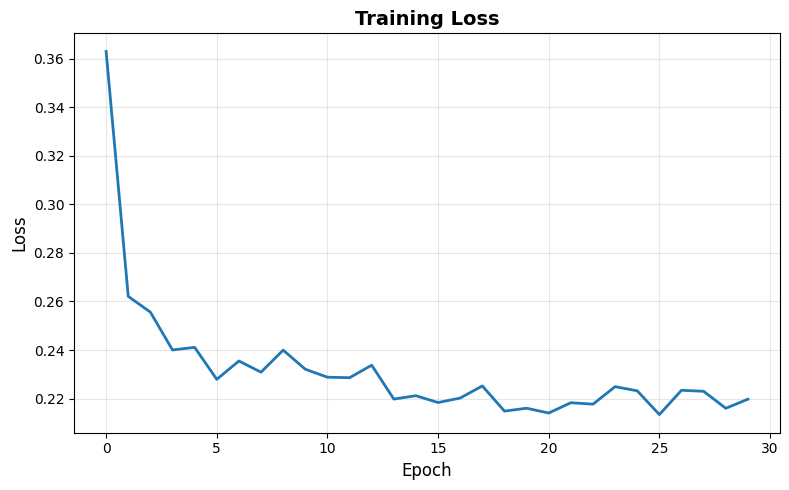

Final loss: 0.2198


In [11]:
# Plot training curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final loss: {loss_history[-1]:.4f}")

---
## 7. Evaluation Setup

In [12]:
dynamics = PointMass2D(dt=config['dt'], max_velocity=max_vel_n, damping=1.0)
rollout  = DifferentiableRollout(dynamics)

sdf = MazeSDF2D(circle_obstacles=[], box_obstacles=train_dataset.box_obstacles)

constraint_fn = ConstraintFunction(
    dynamics, sdf, delta=robot_radius_n + 0.03,
    goal_weight     = 20.0,
    obstacle_weight = 200.0,
    control_weight  = 0.05,
    smooth_weight   = 0.01,
)

projection = ProximalProjection(
    constraint_fn,
    lambda_penalty = 0.5,
    num_steps      = 6,
    lr             = 0.06,
    u_clip         = config['u_clip'],
)

sampler = FeasibleDiffusionSampler(
    diffusion_model, projection,
    project_every=1,   # project at every reverse step
)
print("✓ Evaluation stack ready (Dynobench Integrator2_2d)")


Eval setup: u_clip=0.5  (normalised max action ~0.40)


In [13]:
@torch.no_grad()
def evaluate_controls(controls, x0, x_goal, rollout, sdf, goal_tol=0.12):
    states    = rollout(x0, controls)
    positions = states[..., :2]
    goal_err  = torch.norm(positions[:,-1] - x_goal[...,:2], dim=-1)
    sdf_vals  = sdf(positions)
    # Treat the robot as a disc with radius `robot_radius_n`
    collision = (sdf_vals.min(dim=1).values < robot_radius_n)
    success   = (goal_err < goal_tol) & (~collision)
    return {
        'success_rate' : success.float().mean().item(),
        'collision_rate': collision.float().mean().item(),
        'avg_goal_error': goal_err.mean().item(),
        'success': success.cpu().numpy(),
        'collision': collision.cpu().numpy(),
        'goal_error': goal_err.cpu().numpy(),
    }


Baselines defined
  random_shooting/mppi: fixed nominal = 4*dp/(T*dt)^2  [was dp/(dt*T)]


In [ ]:
# ── Baseline planners (missing in earlier version) ────────────────────────────
# These are used for quick sanity checks / comparisons.

@torch.no_grad()
def diffusion_best_of_k(diffusion_model, constraint_fn, x0, x_goal, T, C,
                        K=32, method='ddim', eta=0.0, u_clip=None):
    """
    Sample K candidate control sequences from the diffusion model and pick the
    lowest-cost one (per batch element) according to `constraint_fn`.

    Returns:
        u_best: [B, T, C]
        info: dict
    """
    device = next(diffusion_model.parameters()).device
    B = x0.shape[0]

    if u_clip is None:
        u_clip = globals().get('config', {}).get('u_clip', None)

    # Condition (compatible with training)
    state_dim = x0.shape[-1]
    cond = create_condition_encoding(x0, x_goal, state_dim=state_dim)  # [B, 2*state_dim]
    cond_rep = cond.repeat_interleave(K, dim=0)                        # [B*K, 2*state_dim]

    # Sample candidates
    u = diffusion_model.sample((B*K, T, C), cond_rep, method=method, eta=eta)  # [B*K, T, C]
    if u_clip is not None:
        u = u.clamp(-float(u_clip), float(u_clip))

    # Evaluate cost and select best per batch element
    x0_rep    = x0.repeat_interleave(K, dim=0)
    xgoal_rep = x_goal.repeat_interleave(K, dim=0)

    costs = constraint_fn(u, x0_rep, xgoal_rep)                         # [B*K]
    costs = costs.view(B, K)                                            # [B, K]
    best_i = torch.argmin(costs, dim=1)                                 # [B]

    u = u.view(B, K, T, C)
    u_best = u[torch.arange(B, device=device), best_i]                  # [B, T, C]
    best_cost = costs[torch.arange(B, device=device), best_i]           # [B]

    info = {'best_cost_mean': best_cost.mean().item(),
            'best_cost_min':  best_cost.min().item(),
            'best_cost_max':  best_cost.max().item()}
    return u_best, info


@torch.no_grad()
def random_shooting(constraint_fn, x0, x_goal, T, C, num_samples=512, u_clip=None, dt=None):
    """
    Sample many random open-loop control sequences and pick the best under
    the constraint/cost function.
    """
    device = x0.device
    B = x0.shape[0]

    if u_clip is None:
        u_clip = globals().get('config', {}).get('u_clip', None)

    # [B, N, T, C]
    u = torch.randn(B, num_samples, T, C, device=device, dtype=x0.dtype)
    if u_clip is not None:
        u = u.clamp(-float(u_clip), float(u_clip))

    # Flatten for batched cost evaluation
    u_flat    = u.view(B*num_samples, T, C)
    x0_rep    = x0.repeat_interleave(num_samples, dim=0)
    xgoal_rep = x_goal.repeat_interleave(num_samples, dim=0)

    costs = constraint_fn(u_flat, x0_rep, xgoal_rep)                    # [B*N]
    costs = costs.view(B, num_samples)

    best_i = torch.argmin(costs, dim=1)                                 # [B]
    u_best = u[torch.arange(B, device=device), best_i]                  # [B, T, C]
    best_cost = costs[torch.arange(B, device=device), best_i]

    info = {'best_cost_mean': best_cost.mean().item(),
            'best_cost_min':  best_cost.min().item(),
            'best_cost_max':  best_cost.max().item()}
    return u_best, info


@torch.no_grad()
def mppi(constraint_fn, x0, x_goal, T, C, dt=None,
         num_samples=256, num_iters=6, lam=1.0, sigma=0.8, u_clip=None):
    """
    Simple open-loop MPPI (vectorised per batch element).
    Returns an open-loop control sequence u [B,T,C].
    """
    device = x0.device
    B = x0.shape[0]

    if u_clip is None:
        u_clip = globals().get('config', {}).get('u_clip', None)

    # Nominal sequence
    u_nom = torch.zeros(B, T, C, device=device, dtype=x0.dtype)

    for _ in range(num_iters):
        noise = torch.randn(B, num_samples, T, C, device=device, dtype=x0.dtype)
        u_cand = u_nom[:, None, :, :] + sigma * noise

        if u_clip is not None:
            u_cand = u_cand.clamp(-float(u_clip), float(u_clip))

        u_flat    = u_cand.view(B*num_samples, T, C)
        x0_rep    = x0.repeat_interleave(num_samples, dim=0)
        xgoal_rep = x_goal.repeat_interleave(num_samples, dim=0)

        costs = constraint_fn(u_flat, x0_rep, xgoal_rep).view(B, num_samples)

        # Stable weights: exp(-(J - Jmin)/lam)
        Jmin = costs.min(dim=1, keepdim=True).values
        w = torch.exp(-(costs - Jmin) / max(lam, 1e-6))
        w = w / (w.sum(dim=1, keepdim=True) + 1e-9)

        # Weighted update
        u_nom = (w[:, :, None, None] * u_cand).sum(dim=1)

    info = {'final_cost_mean': constraint_fn(u_nom, x0, x_goal).mean().item()}
    return u_nom, info


print("✓ Baseline planners defined: diffusion_best_of_k, random_shooting, mppi")


In [14]:
# Quick baseline comparison on one training batch
batch  = next(iter(train_loader))
x0     = batch['x0'].to(device)
x_goal = batch['x_goal'].to(device)
B, T, C = x0.shape[0], config['horizon'], config['control_dim']

u_diff,  _ = diffusion_best_of_k(diffusion_model, constraint_fn, x0, x_goal, T, C, K=32)
u_proj,  _ = sampler.sample(B, T, x0, x_goal, method='ddim', eta=0.0)
u_shoot, _ = random_shooting(constraint_fn, x0, x_goal, T, C, dt=config['dt'])
u_mppi,  _ = mppi(constraint_fn, x0, x_goal, T, C, dt=config['dt'])

for name, u in [("Diffusion (no proj)", u_diff), ("Diffusion+projection", u_proj),
                ("Random shooting",     u_shoot), ("MPPI",                u_mppi)]:
    m = evaluate_controls(u, x0, x_goal, rollout, sdf)
    print(f"  {name:28s}  success={100*m['success_rate']:.1f}%  "
          f"collision={100*m['collision_rate']:.1f}%  goal_err={m['avg_goal_error']:.3f}")


  Diffusion (no proj)           success=0.0%  collision=100.0%  goal_err=2.470
  Diffusion+projection          success=0.0%  collision=100.0%  goal_err=1.529
  Random shooting               success=0.0%  collision=100.0%  goal_err=3.003
  MPPI                          success=0.0%  collision=100.0%  goal_err=1.922


---
## 8. Visualization — Single Scenario

In [15]:
# Single test case (use the canonical Dynobench start/goal from park.yaml)
x0_state = torch.tensor(start_n[None], dtype=torch.float32, device=device)
x_goal   = torch.tensor(goal_n[None],  dtype=torch.float32, device=device)

diffusion_model.eval()
cond = create_condition_encoding(x0_state, x_goal, state_dim=config['state_dim'])

u_no = diffusion_model.sample((1, config['horizon'], config['control_dim']), cond).clamp(-config['u_clip'], config['u_clip'])
u_yes, _ = projection.project(u_no.clone(), x0_state, x_goal)

sno  = rollout(x0_state, u_no)
syes = rollout(x0_state, u_yes)

ok_no  = (sdf(sno[..., :2]).min().item()  > robot_radius_n)
ok_yes = (sdf(syes[..., :2]).min().item() > robot_radius_n)


Without projection: goal_err=1.111  min_sdf=0.049  collision=False  success=False
With projection: goal_err=1.007  min_sdf=0.050  collision=False  success=False


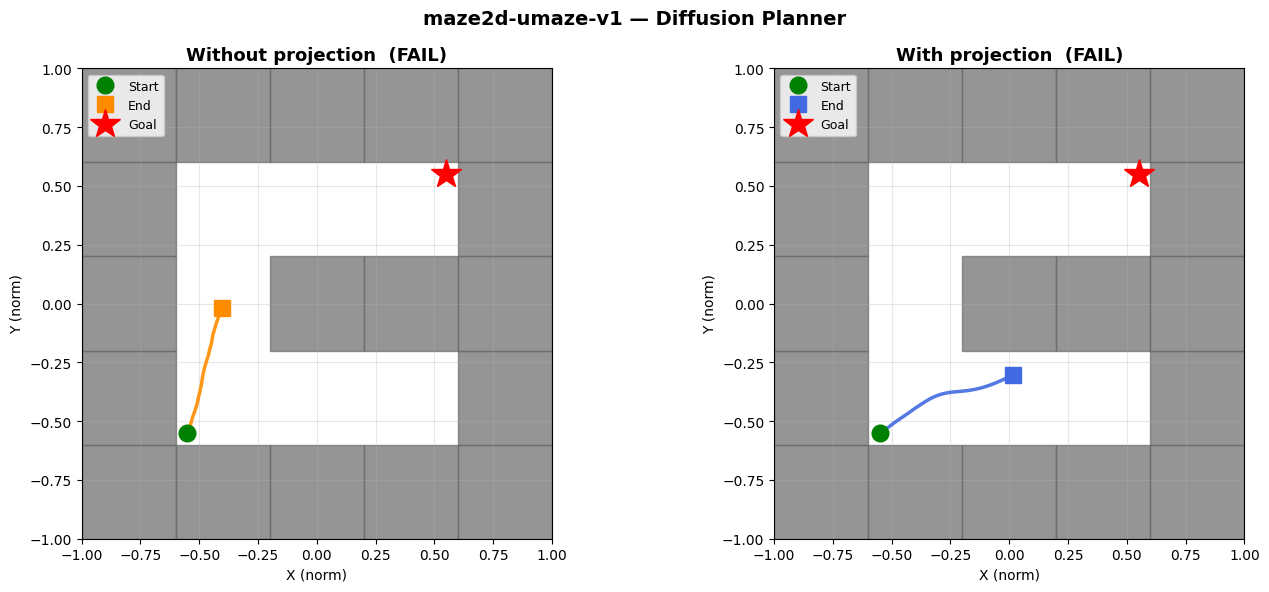

In [16]:
def draw_env(ax, boxes, env_min=None, env_max=None):
    for (cx,cy),(hx,hy) in boxes:
        ax.add_patch(Rectangle((cx-hx, cy-hy), 2*hx, 2*hy,
                                color='dimgray', alpha=0.7, zorder=1))
    if env_min is not None and env_max is not None:
        ax.set_xlim(env_min[0], env_max[0]); ax.set_ylim(env_min[1], env_max[1])
    ax.set_aspect('equal', 'box')
    ax.grid(True, alpha=0.2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
gx, gy = x_goal[0,0].item(), x_goal[0,1].item()

for i, (st, title, color, ok) in enumerate([
    (sno,  'Without projection', 'darkorange', ok_no),
    (syes, 'With projection',    'royalblue',  ok_yes),
]):
    ax = axes[i]
    draw_env(ax, train_dataset.box_obstacles)
    ax.plot(st[0,:,0].cpu(), st[0,:,1].cpu(), '-', lw=3, color=color, zorder=3)
    ax.scatter([x0_state[0,0].item()], [x0_state[0,1].item()], c='lime', s=120, edgecolor='k', zorder=4, label='Start')
    ax.scatter([gx], [gy], c='red', s=120, edgecolor='k', zorder=4, label='Goal')
    ax.set_title(f"{title}  |  collision-free={ok}", fontsize=13, fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.show()


---
## 9. Batch Evaluation

In [ ]:
num_test  = 200
goal_tol  = 0.12       # normalised position tolerance
min_dist  = 0.35

def sample_dynobench_pair(sdf, n_tries=5000):
    env_min_n = norm["npos"](env_cfg["env_min"])
    env_max_n = norm["npos"](env_cfg["env_max"])
    for _ in range(n_tries):
        s = torch.tensor(np.random.uniform(env_min_n, env_max_n, (1,2)),
                         dtype=torch.float32, device=device)
        g = torch.tensor(np.random.uniform(env_min_n, env_max_n, (1,2)),
                         dtype=torch.float32, device=device)
        if (sdf(s[0]).item() > (robot_radius_n + 0.05)
                and sdf(g[0]).item() > (robot_radius_n + 0.05)
                and torch.norm(s-g).item() > min_dist):
            s_state = torch.cat([s, torch.zeros(1,2,device=device)], -1)
            g_state = torch.cat([g, torch.zeros(1,2,device=device)], -1)
            return s_state, g_state
    raise RuntimeError("Could not sample a valid (start, goal) pair")

test_pairs = [sample_dynobench_pair(sdf) for _ in range(num_test)]
print(f"✓ Sampled {len(test_pairs)} Dynobench start/goal pairs")

# ── Evaluate diffusion w/ and w/o projection ──────────────────────────────────
diffusion_model.eval()
T, C = config['horizon'], config['control_dim']

results_no_proj   = []
results_with_proj = []

for (x0, x_goal) in tqdm(test_pairs, desc="Evaluating"):
    x0     = x0.to(device)
    x_goal = x_goal.to(device)
    cond = create_condition_encoding(x0, x_goal, state_dim=config['state_dim'])

    # Sample controls
    t0 = time.time()
    u_no = diffusion_model.sample((1, T, C), cond).clamp(-config['u_clip'], config['u_clip'])
    t1 = time.time()
    m_no = evaluate_controls(u_no, x0, x_goal, rollout, sdf, goal_tol=goal_tol)
    results_no_proj.append({
        'success'   : bool(m_no['success'][0]),
        'collision' : bool(m_no['collision'][0]),
        'goal_error': float(m_no['goal_error'][0]),
        'time_s'    : float(t1 - t0),
    })

    # Projection
    t0 = time.time()
    u_yes, _ = projection.project(u_no.clone(), x0, x_goal)
    t1 = time.time()
    m_yes = evaluate_controls(u_yes, x0, x_goal, rollout, sdf, goal_tol=goal_tol)
    results_with_proj.append({
        'success'   : bool(m_yes['success'][0]),
        'collision' : bool(m_yes['collision'][0]),
        'goal_error': float(m_yes['goal_error'][0]),
        'time_s'    : float(t1 - t0),
    })

print("✓ Done. Next cell computes summary statistics.")


Evaluating 400 test cases ...


Testing:   0%|          | 0/400 [00:00<?, ?it/s]


Done in 1494.0s


In [ ]:
# Compute statistics (with uncertainty) + timing
def compute_stats(results, name):
    success = np.array([r['success'] for r in results], dtype=np.float64)
    collision = np.array([r['collision'] for r in results], dtype=np.float64)
    goal_error = np.array([r['goal_error'] for r in results], dtype=np.float64)

    # timing is optional (won't break old results)
    has_time = ('time_s' in results[0])
    if has_time:
        times = np.array([r['time_s'] for r in results], dtype=np.float64)

    success_rate = success.mean() * 100.0
    collision_rate = collision.mean() * 100.0
    avg_goal_error = goal_error.mean()

    n = len(results)

    # standard errors
    se_success = np.sqrt(max(success.mean() * (1 - success.mean()), 1e-9) / n) * 100.0
    se_collision = np.sqrt(max(collision.mean() * (1 - collision.mean()), 1e-9) / n) * 100.0
    se_goal = goal_error.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0

    out = {
        'name': name,
        'n': n,
        'success_rate': success_rate,
        'collision_rate': collision_rate,
        'avg_goal_error': avg_goal_error,
        'se_success': se_success,
        'se_collision': se_collision,
        'se_goal': se_goal,
    }

    if has_time:
        out.update({
            'avg_time_s': times.mean(),
            'se_time_s': (times.std(ddof=1) / np.sqrt(n)) if n > 1 else 0.0,
            'median_time_s': np.median(times),
            'p90_time_s': np.percentile(times, 90),
        })

    return out

stats_no = compute_stats(results_no_proj, "Without projection")
stats_yes = compute_stats(results_with_proj, "With projection")

print("\nBatch results:")
for s in [stats_no, stats_yes]:
    print(f"\n{s['name']} (n={s['n']}):")
    print(f"  Success rate:   {s['success_rate']:.1f}% ± {s['se_success']:.1f}% (SE)")
    print(f"  Collision rate: {s['collision_rate']:.1f}% ± {s['se_collision']:.1f}% (SE)")
    print(f"  Avg goal error: {s['avg_goal_error']:.3f} ± {s['se_goal']:.3f} (SE)")

    if 'avg_time_s' in s:
        print(f"  Avg time:       {s['avg_time_s']*1000:.1f} ms ± {s['se_time_s']*1000:.1f} ms (SE)")
        print(f"  Median / P90:   {s['median_time_s']*1000:.1f} ms / {s['p90_time_s']*1000:.1f} ms")



Batch results:

Without projection (n=400):
  Success rate:   30.5% ± 2.3% (SE)
  Collision rate: 24.0% ± 2.1% (SE)
  Avg goal error: 0.431 ± 0.014 (SE)
  Avg time:       446.8 ms ± 1.1 ms (SE)
  Median / P90:   439.3 ms / 482.8 ms

With projection (n=400):
  Success rate:   67.8% ± 2.3% (SE)
  Collision rate: 6.5% ± 1.2% (SE)
  Avg goal error: 0.227 ± 0.012 (SE)
  Avg time:       3282.0 ms ± 14.3 ms (SE)
  Median / P90:   3134.8 ms / 3736.0 ms


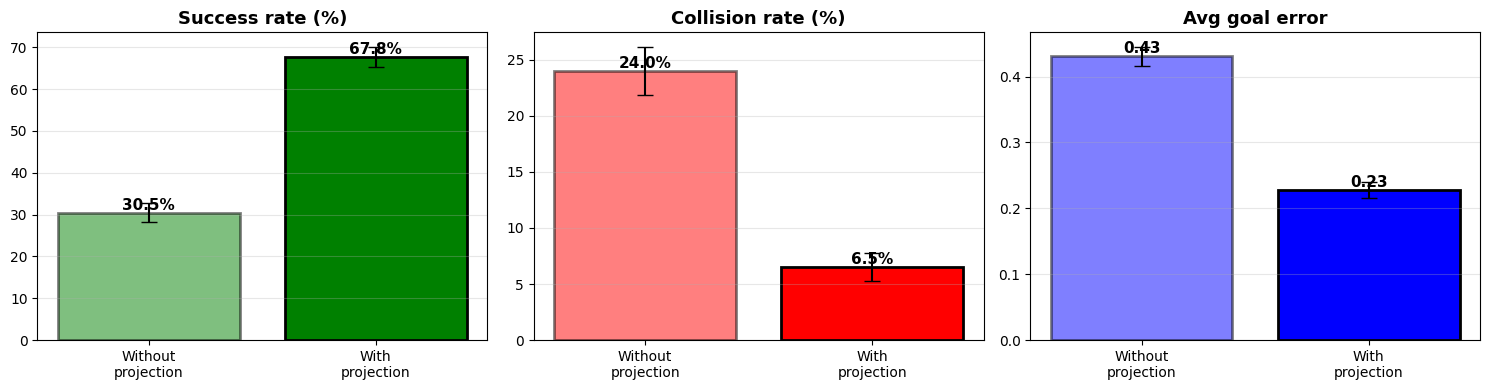

In [ ]:
# Visualization of statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['success_rate', 'collision_rate', 'avg_goal_error']
titles = ['Success rate (%)', 'Collision rate (%)', 'Avg goal error']
colors = ['green', 'red', 'blue']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[i]
    labels = ['Without\nprojection', 'With\nprojection']
    values = [stats_no[metric], stats_yes[metric]]

    bars = ax.bar(labels, values, color=[color, color], edgecolor='black', linewidth=2)
    bars[0].set_alpha(0.5)
    bars[1].set_alpha(1.0)

    # Error bars for rates/errors
    if metric == 'success_rate':
        yerr = [stats_no['se_success'], stats_yes['se_success']]
        ax.errorbar([0, 1], values, yerr=yerr, fmt='none', capsize=6, color='black')
    elif metric == 'collision_rate':
        yerr = [stats_no['se_collision'], stats_yes['se_collision']]
        ax.errorbar([0, 1], values, yerr=yerr, fmt='none', capsize=6, color='black')
    else:
        yerr = [stats_no['se_goal'], stats_yes['se_goal']]
        ax.errorbar([0, 1], values, yerr=yerr, fmt='none', capsize=6, color='black')

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for b, v in zip(bars, values):
        ax.text(b.get_x() + b.get_width() / 2, b.get_height(),
                f"{v:.2f}" if metric == 'avg_goal_error' else f"{v:.1f}%",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


---
## 10. Ablation Study — Projection Penalty λ

In [ ]:
# Ablation: test different lambda values
lambda_values = [0.01, 0.05, 0.1, 0.5]
ablation_results = []

print("Running lambda ablation...\n")

test_cases_per_lambda = 30

# Use the same goal tolerance as the batch eval section (or default).
goal_tol = globals().get('goal_tol', 0.20)

for lam in lambda_values:
    print(f"Testing λ = {lam}...")

    proj_test = ProximalProjection(
        constraint_fn,
        lambda_penalty=lam,
        num_steps=6,
        lr=0.06,
        u_clip=config['u_clip']
    )

    sampler_test = FeasibleDiffusionSampler(
        diffusion_model,
        proj_test,
        project_every=10
    )

    successes = []
    collisions = []
    goal_errs = []

    for _ in range(test_cases_per_lambda):
        start, goal = sample_maze_pair(sdf)
        controls, _ = sampler_test.sample(batch_size=1, T=config['horizon'], x0=start, x_goal=goal)
        states = rollout(start, controls)

        final_pos = states[0, -1, :2]
        goal_error = torch.norm(final_pos - goal[0]).item()
        sdf_vals = sdf(states[0, :, :2])
        collision = (sdf_vals.min() < 0.0).item()
        success = (goal_error < goal_tol) and (not collision)

        successes.append(success)
        collisions.append(collision)
        goal_errs.append(goal_error)

    ablation_results.append({
        'lambda': lam,
        'success_rate': np.mean(successes) * 100,
        'collision_rate': np.mean(collisions) * 100,
        'avg_goal_error': float(np.mean(goal_errs))
    })

print("\n✓ Ablation complete!")

Running lambda ablation...

Testing λ = 0.01...


NameError: name 'sample_valid_pair' is not defined

In [ ]:
# Plot ablation results
fig, ax = plt.subplots(figsize=(10, 5))

lambdas = [r['lambda'] for r in ablation_results]
success_rates = [r['success_rate'] for r in ablation_results]
collision_rates = [r['collision_rate'] for r in ablation_results]

ax.plot(lambdas, success_rates, 'o-', linewidth=2, markersize=10, label='Success Rate', color='green')
ax.plot(lambdas, collision_rates, 's-', linewidth=2, markersize=10, label='Collision Rate', color='red')

ax.set_xlabel('Lambda (λ)', fontsize=13)
ax.set_ylabel('Rate (%)', fontsize=13)
ax.set_title('Ablation: Effect of Lambda on Performance', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

best_lambda = ablation_results[np.argmax([r['success_rate'] for r in ablation_results])]['lambda']
print(f"\nBest λ value: {best_lambda}")

---
## 🎉 Dynobench Adaptation Complete!

Key changes from the D4RL version:

| Component | D4RL (maze2d) | Dynobench (this notebook) |
|---|---|---|
| Data source | HDF5 offline RL dataset | Dynobench env spec + generated offline dataset |
| Environment | U-maze grid | `integrator2_2d_v0/park` (box obstacles) |
| Normalisation | fixed POS_SCALE for `[0,5]` maze | env-based centre/scale from Dynobench bounds |
| Success criterion | goal tolerance + no collision | same (tuned to Dynobench scale) |

If your success rate is still ~0, the usual causes are:
- `goal_tol` too small for the normalisation scale,
- `u_clip` too small relative to `max_acc_n`,
- insufficient training epochs / too small dataset (`num_trajectories`).

Try increasing `goal_tol` (e.g. 0.15) and/or training longer.
